In [137]:
import matplotlib.pyplot as plt
import numpy as np
import rospy
import pickle
plt_dpi = 200

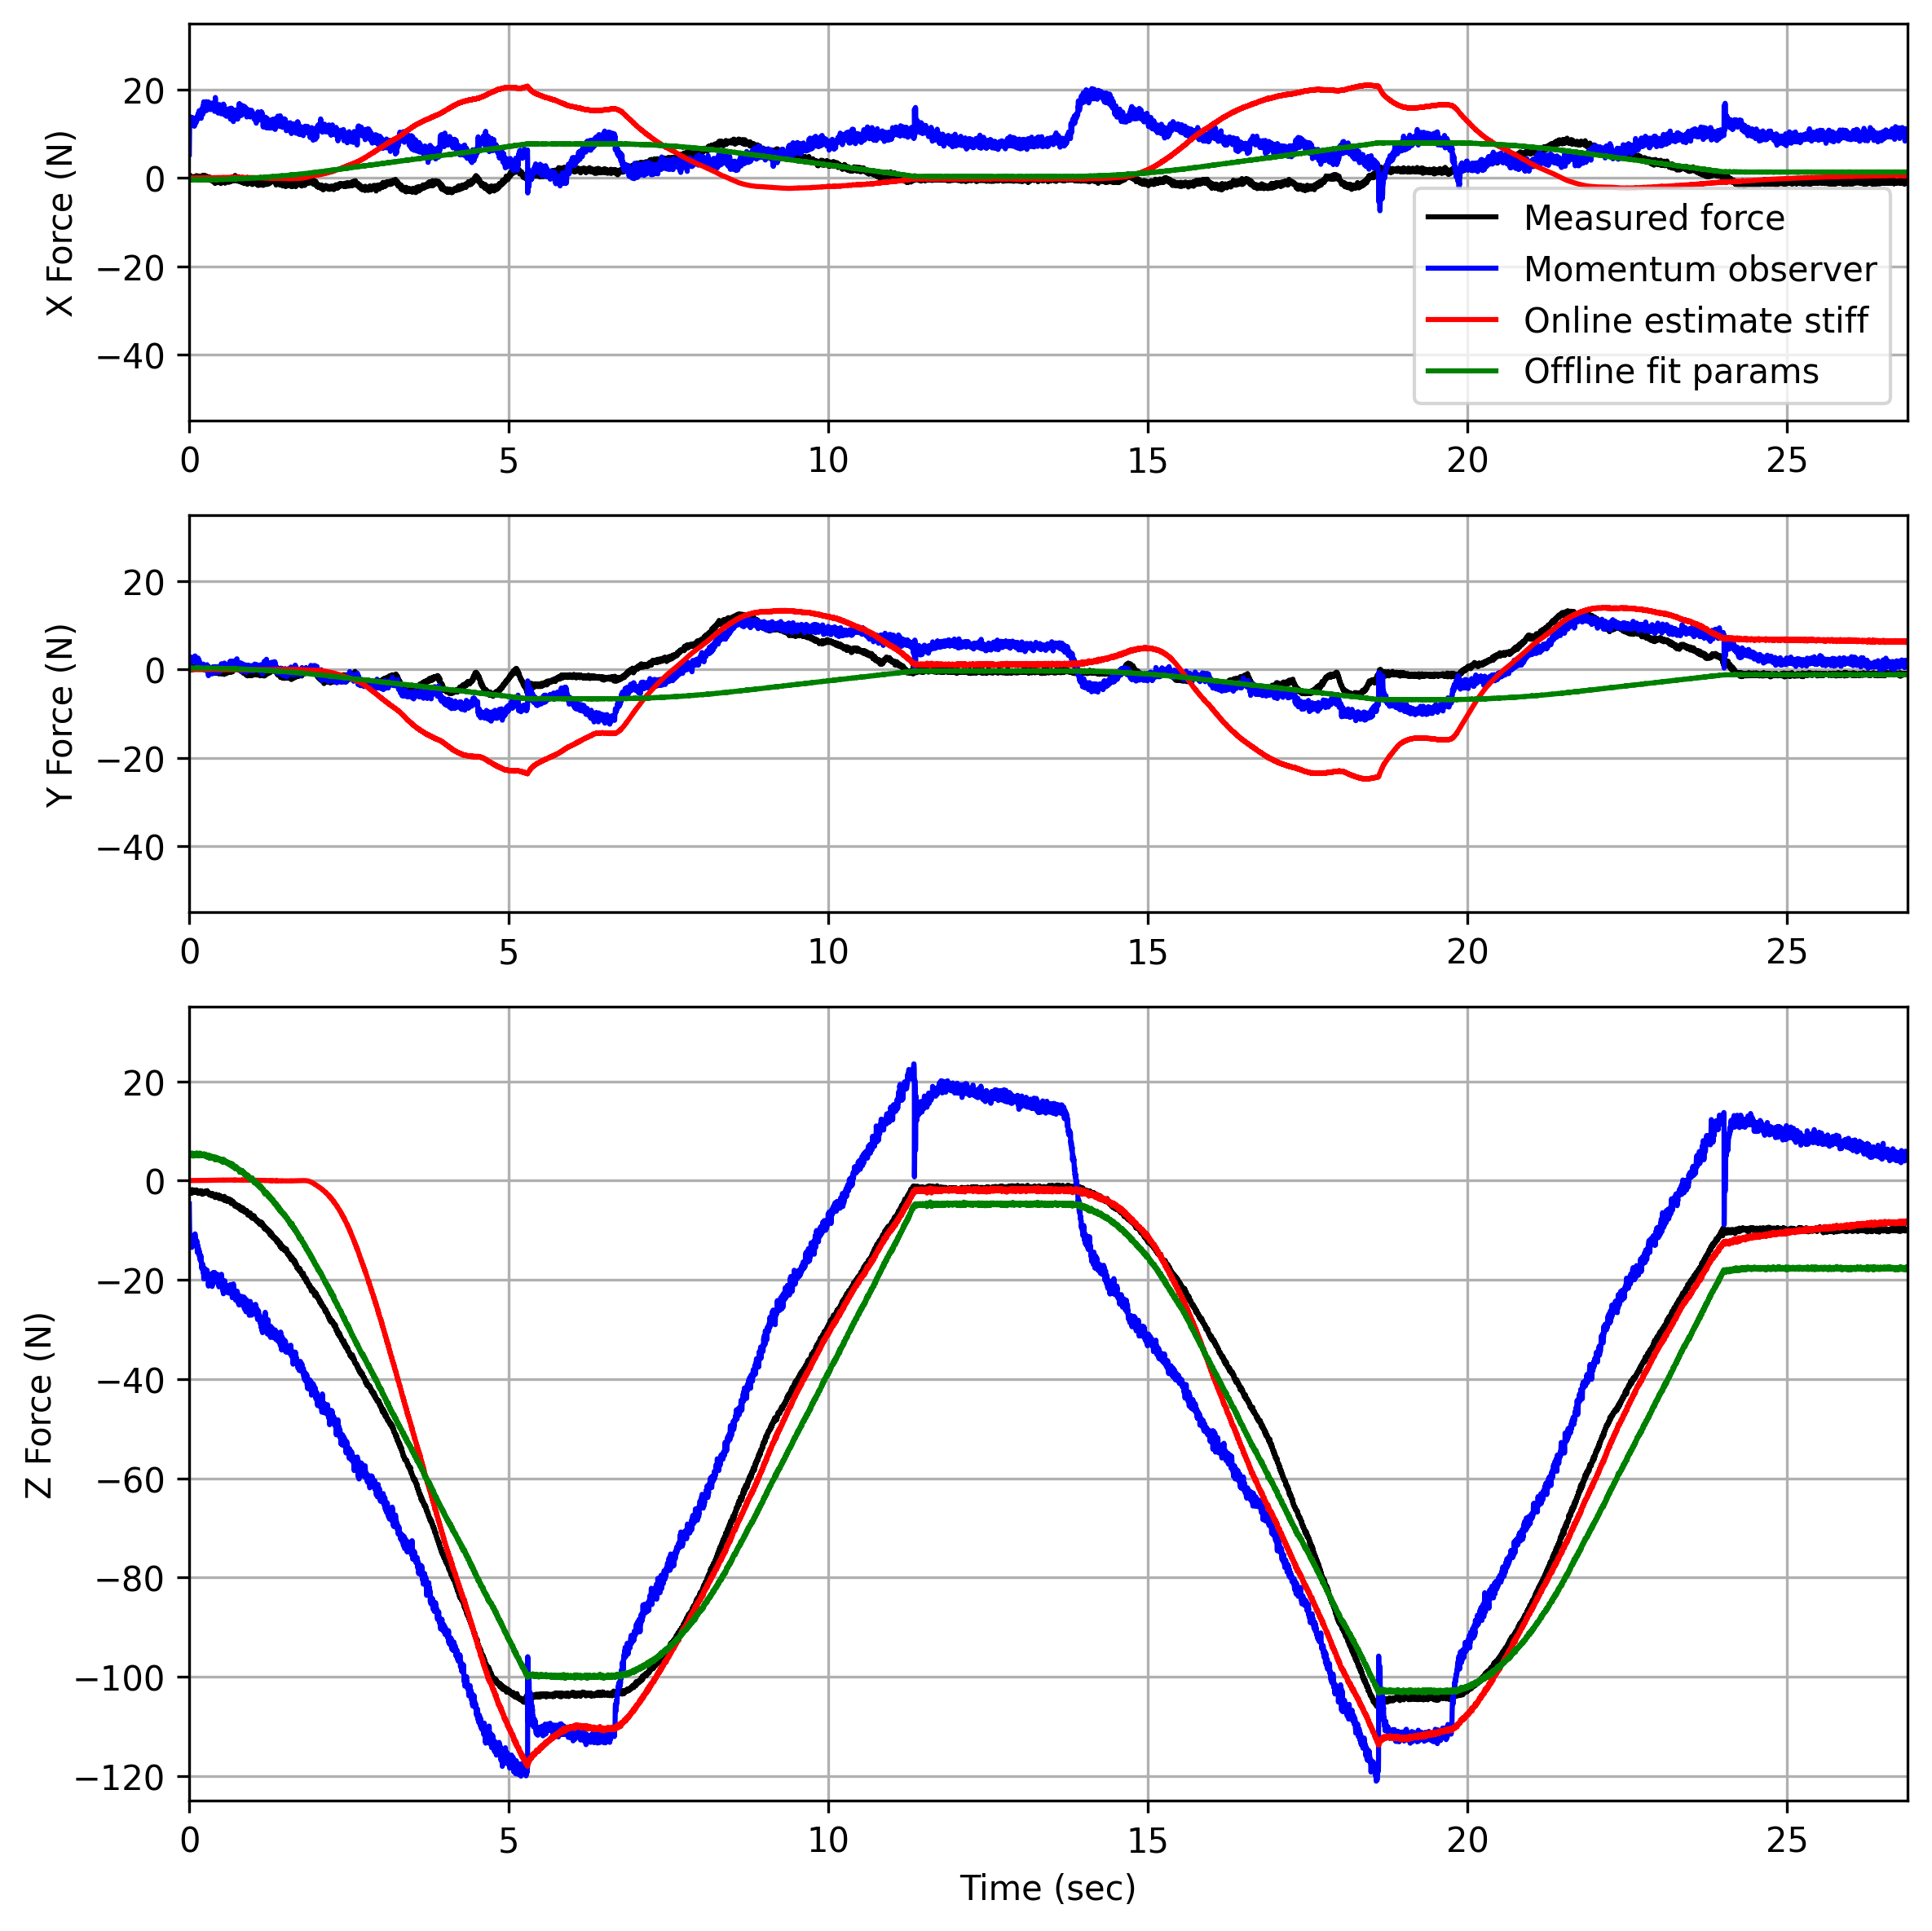

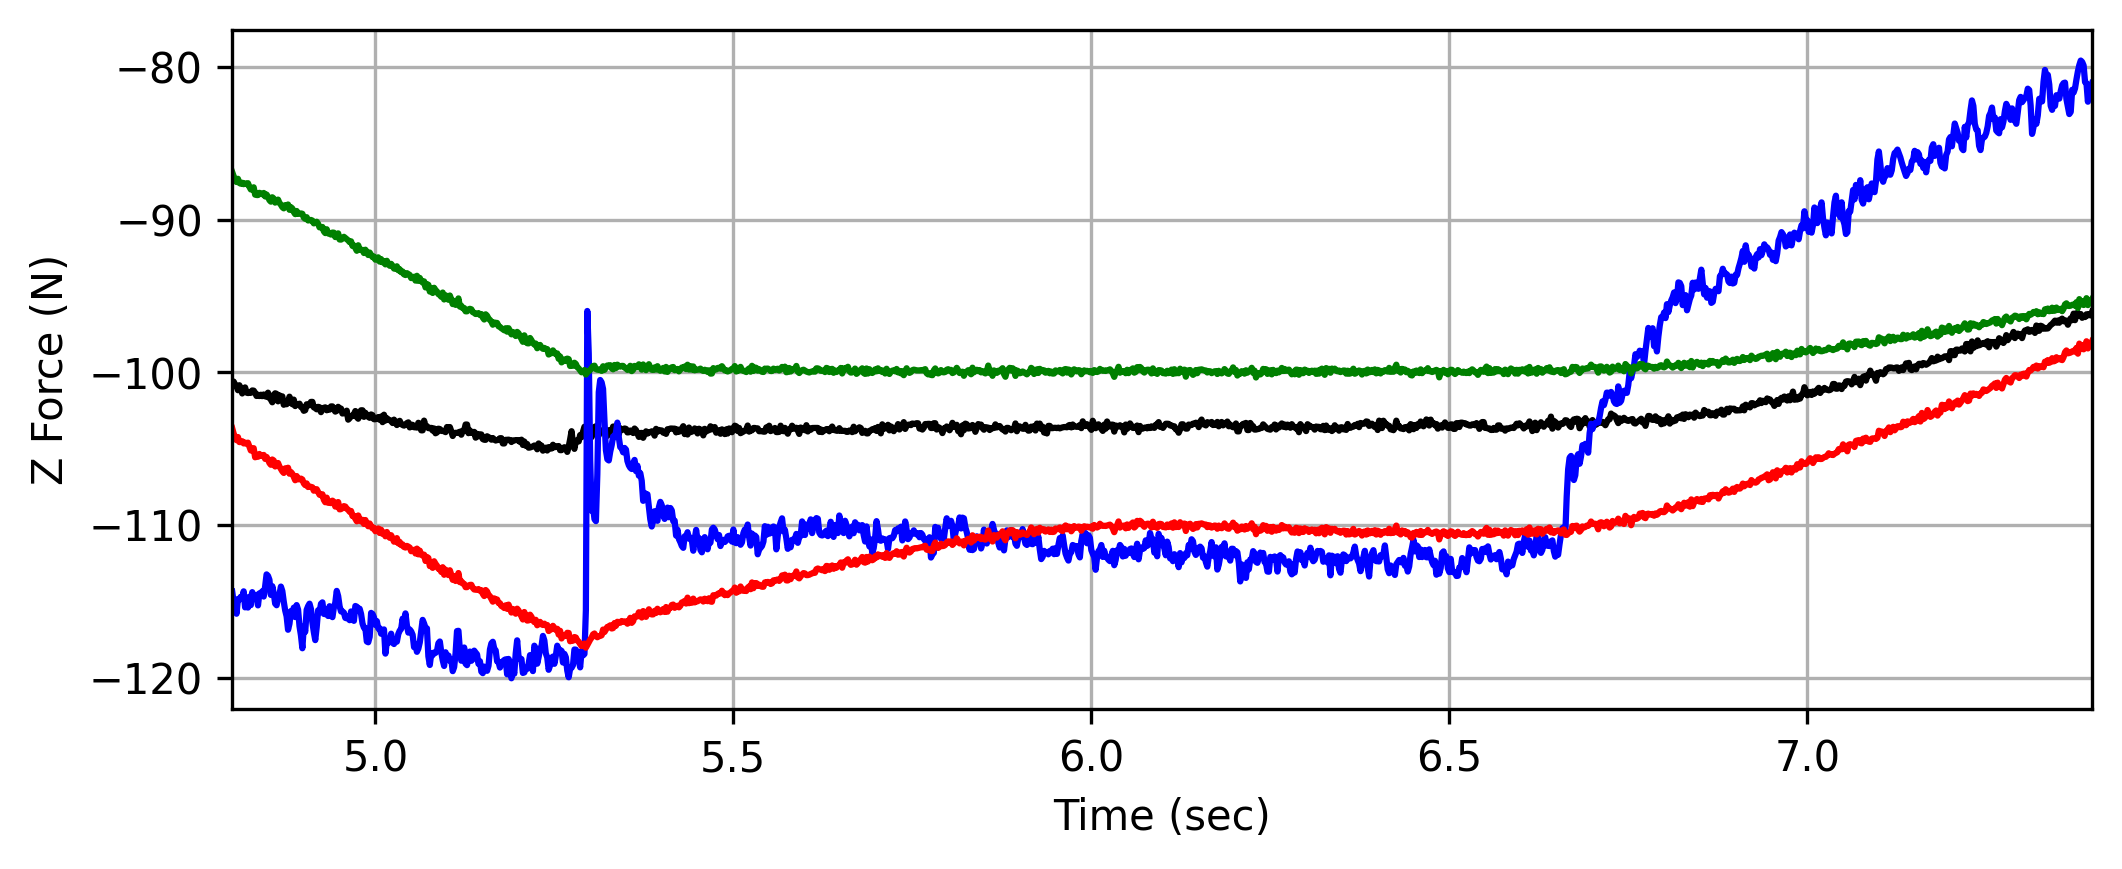

<Figure size 432x288 with 0 Axes>

In [143]:
# Plotting the estimated force, observer force, measured force

traj = 'data/ur_vertical_3_stiff.pkl' # estimating stiffness online
with open(traj, 'rb') as f:
    states, _, _, _, stiff, _, f_ee_obs_stiff, f_ee, true_pos, true_vel = pickle.load(f)

#traj = 'data/ur_vertical_3_offline.pkl' # all fit parameters
traj = 'data/ur_vertical_3.pkl' # all fit parameters
with open(traj, 'rb') as f:
    _, _, _, _, _, f_ee_mo, f_ee_obs_off, f_ee, _, _ = pickle.load(f)

    
f_ee[0,:] *= -1
f_ee[1,:] *= -1    

fig, axs = plt.subplots(3,1,figsize=(8,8), gridspec_kw={'height_ratios': [1, 1, 2]}, dpi=plt_dpi)
t = np.array([range(f_ee.shape[1])]).squeeze()/500.
time = t#range(0,5000)

for ind, ax in enumerate(axs):
    axs[ind].plot(t, f_ee[ind], 'k', label="Measured force")
    axs[ind].plot(t, f_ee_mo[ind], 'b', label= "Momentum observer")
    axs[ind].plot(t, f_ee_obs_stiff[ind], 'r', label= "Online estimate stiff")
    axs[ind].plot(t, f_ee_obs_off[ind], 'g', label= "Offline fit params")
    axs[ind].grid(True)
    axs[ind].set_xlim([t[0],t[-1]])
axs[0].legend() 
axs[0].set_ylim([-55,35])
axs[1].set_ylim([-55,35])
axs[2].set_ylim([-125,35])
axs[0].set_ylabel('X Force (N)')
axs[1].set_ylabel('Y Force (N)')
axs[2].set_ylabel('Z Force (N)')

#plt.xlabel('Force (N)')
#fig.text(0.04, 0.5, 'Force (N)', va='center', rotation='vertical')
plt.xlabel('Time (sec)')
plt.tight_layout()
#plt.savefig('figs/force_comparison.pdf')

plt.figure(figsize=(8,3), dpi=plt_dpi)
time = range(2400, 7*500+200)
t = np.array([time]).squeeze()/500.

ind = 2
plt.plot(t, f_ee[ind,time], 'k', label="Measured force")
plt.plot(t, f_ee_mo[ind,time], 'b', label= "Momentum observer")
plt.plot(t, f_ee_obs_stiff[ind,time], 'r', label= "Online estimate stiff")
plt.plot(t, f_ee_obs_off[ind,time], 'g', label= "Offline fit params")
plt.grid(True)
plt.xlim([t[0],t[-1]])
plt.xlabel('Time (sec)')
plt.ylabel('Z Force (N)')
plt.show()
plt.tight_layout()
plt.savefig('figs/force_comparison_zoom.pdf')

/tmp/ipykernel_8504/2157836836.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Kx, _, _, _ = np.linalg.lstsq(x_reg[[0,-1],:].T, f_ee_w[0].T)
/tmp/ipykernel_8504/2157836836.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Ky, _, _, _ = np.linalg.lstsq(x_reg[[1,-1],:].T, f_ee_w[1].T)
/tmp/ipykernel_8504/2157836836.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this war

[-165037.7231867    67355.11681039] [-137023.60489353  -41706.43816382] [-25955.1954931    3381.34509264]


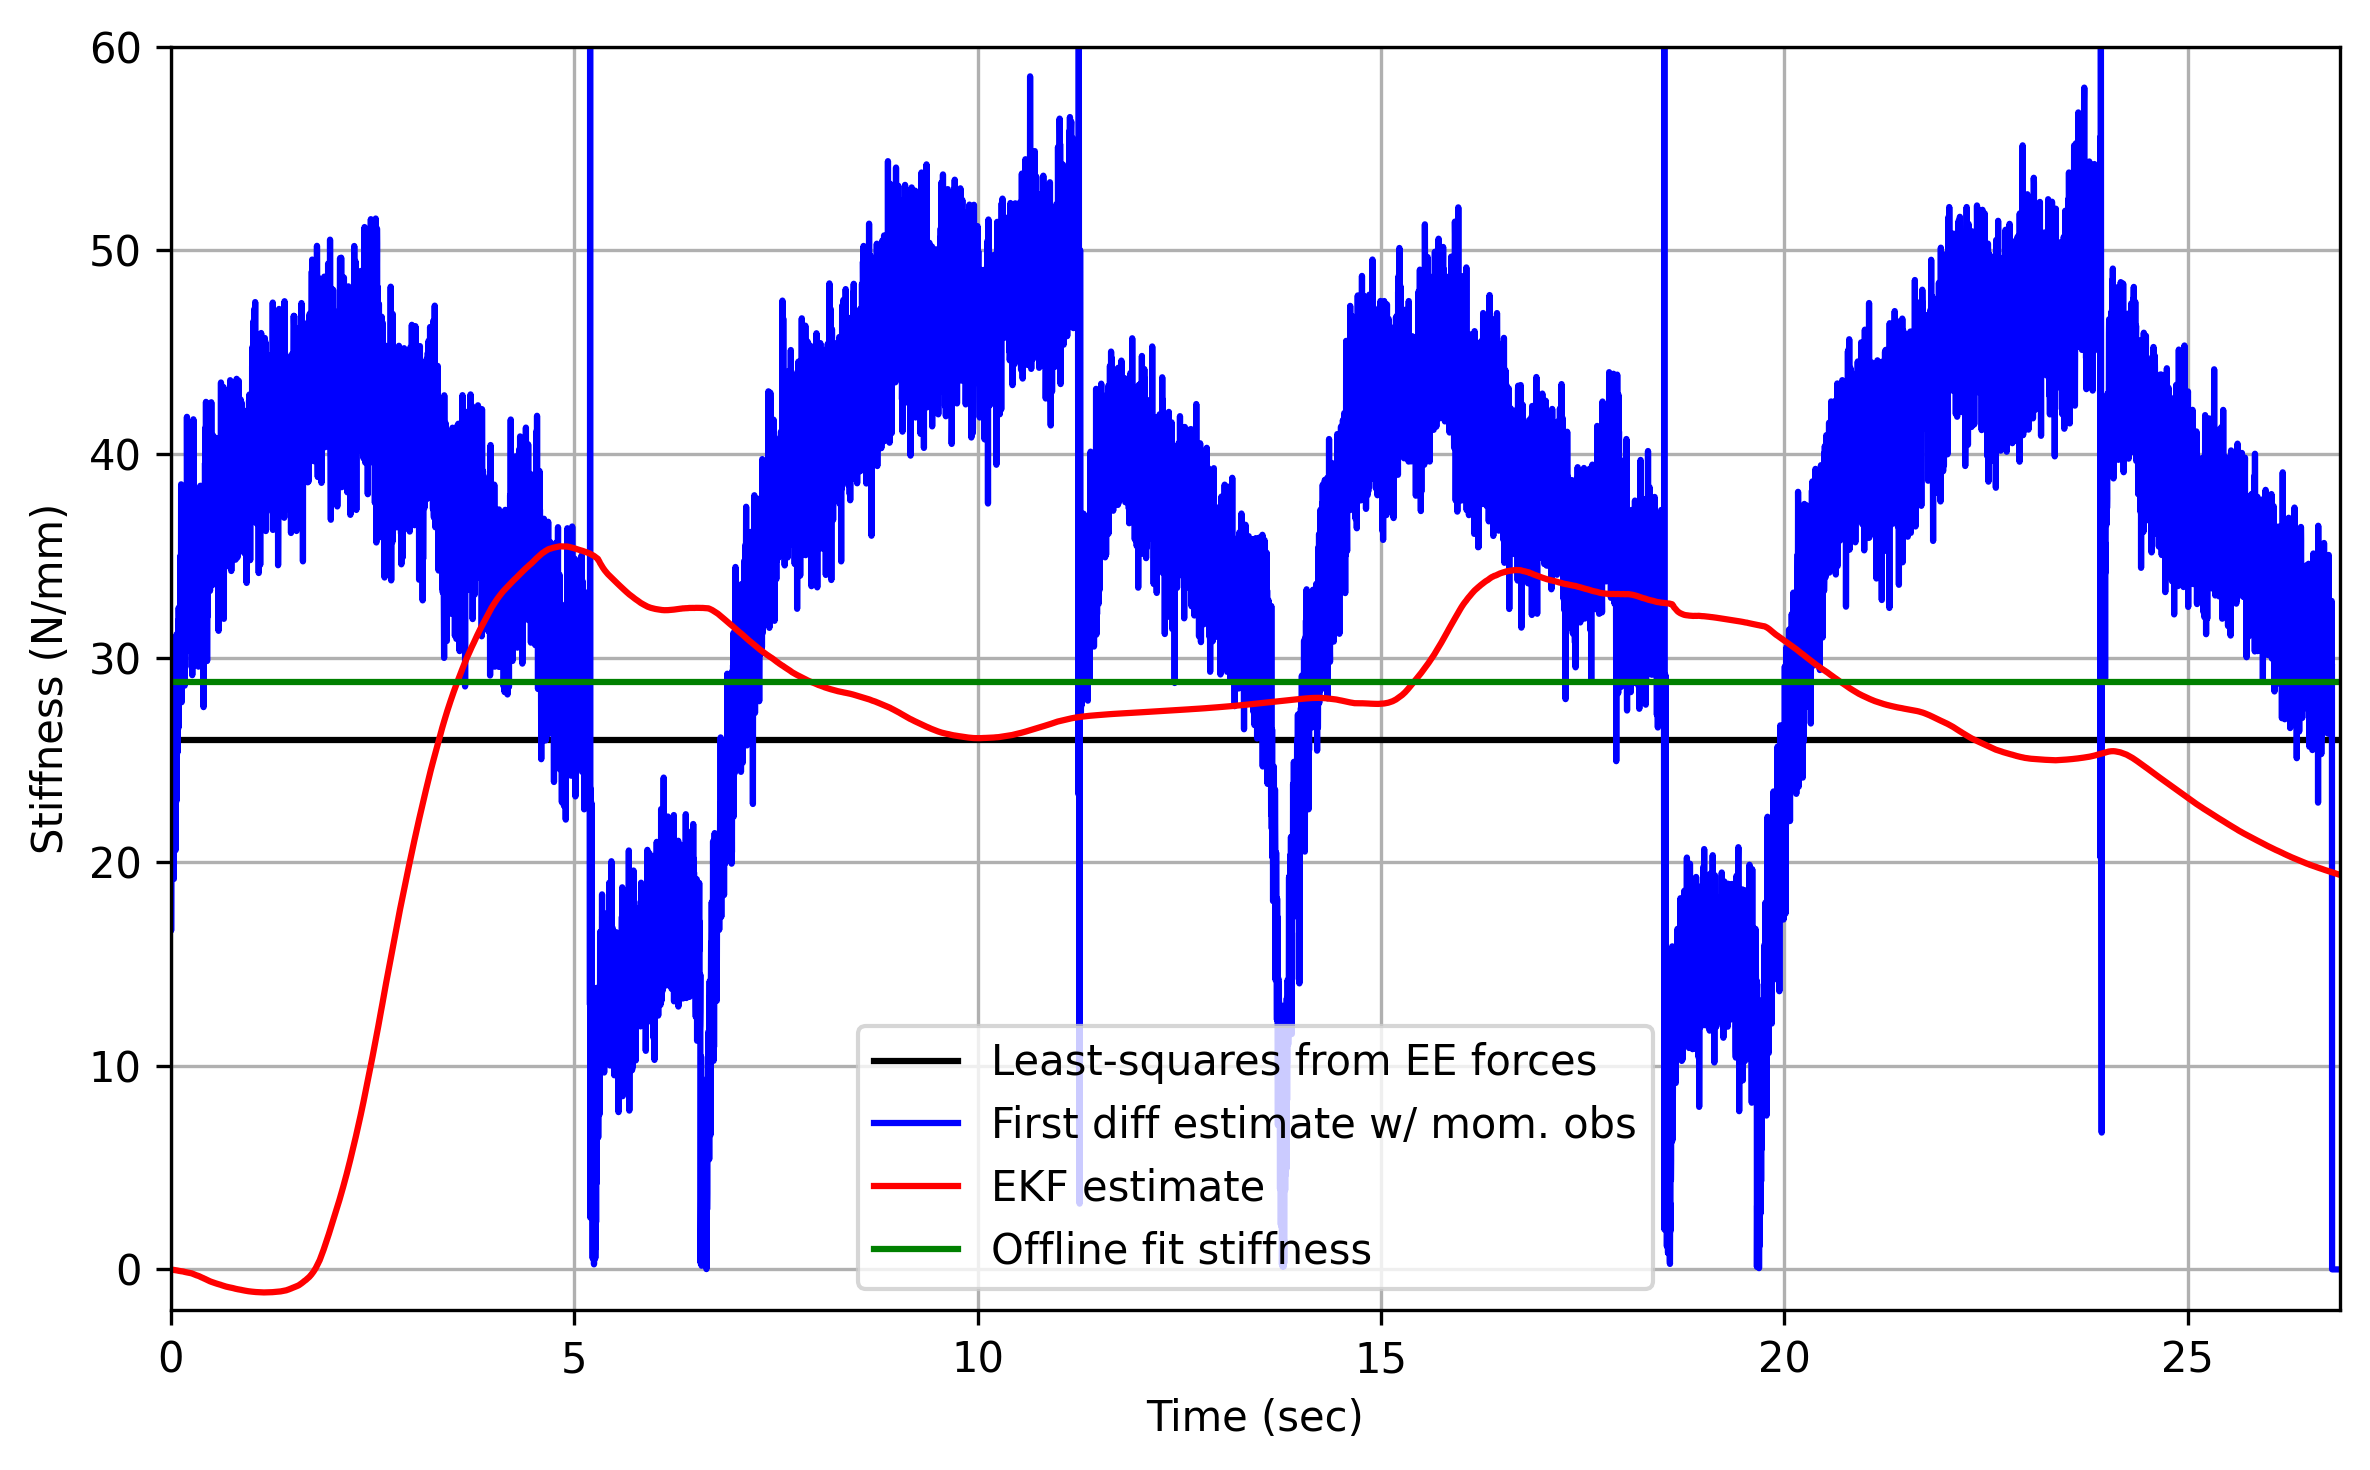

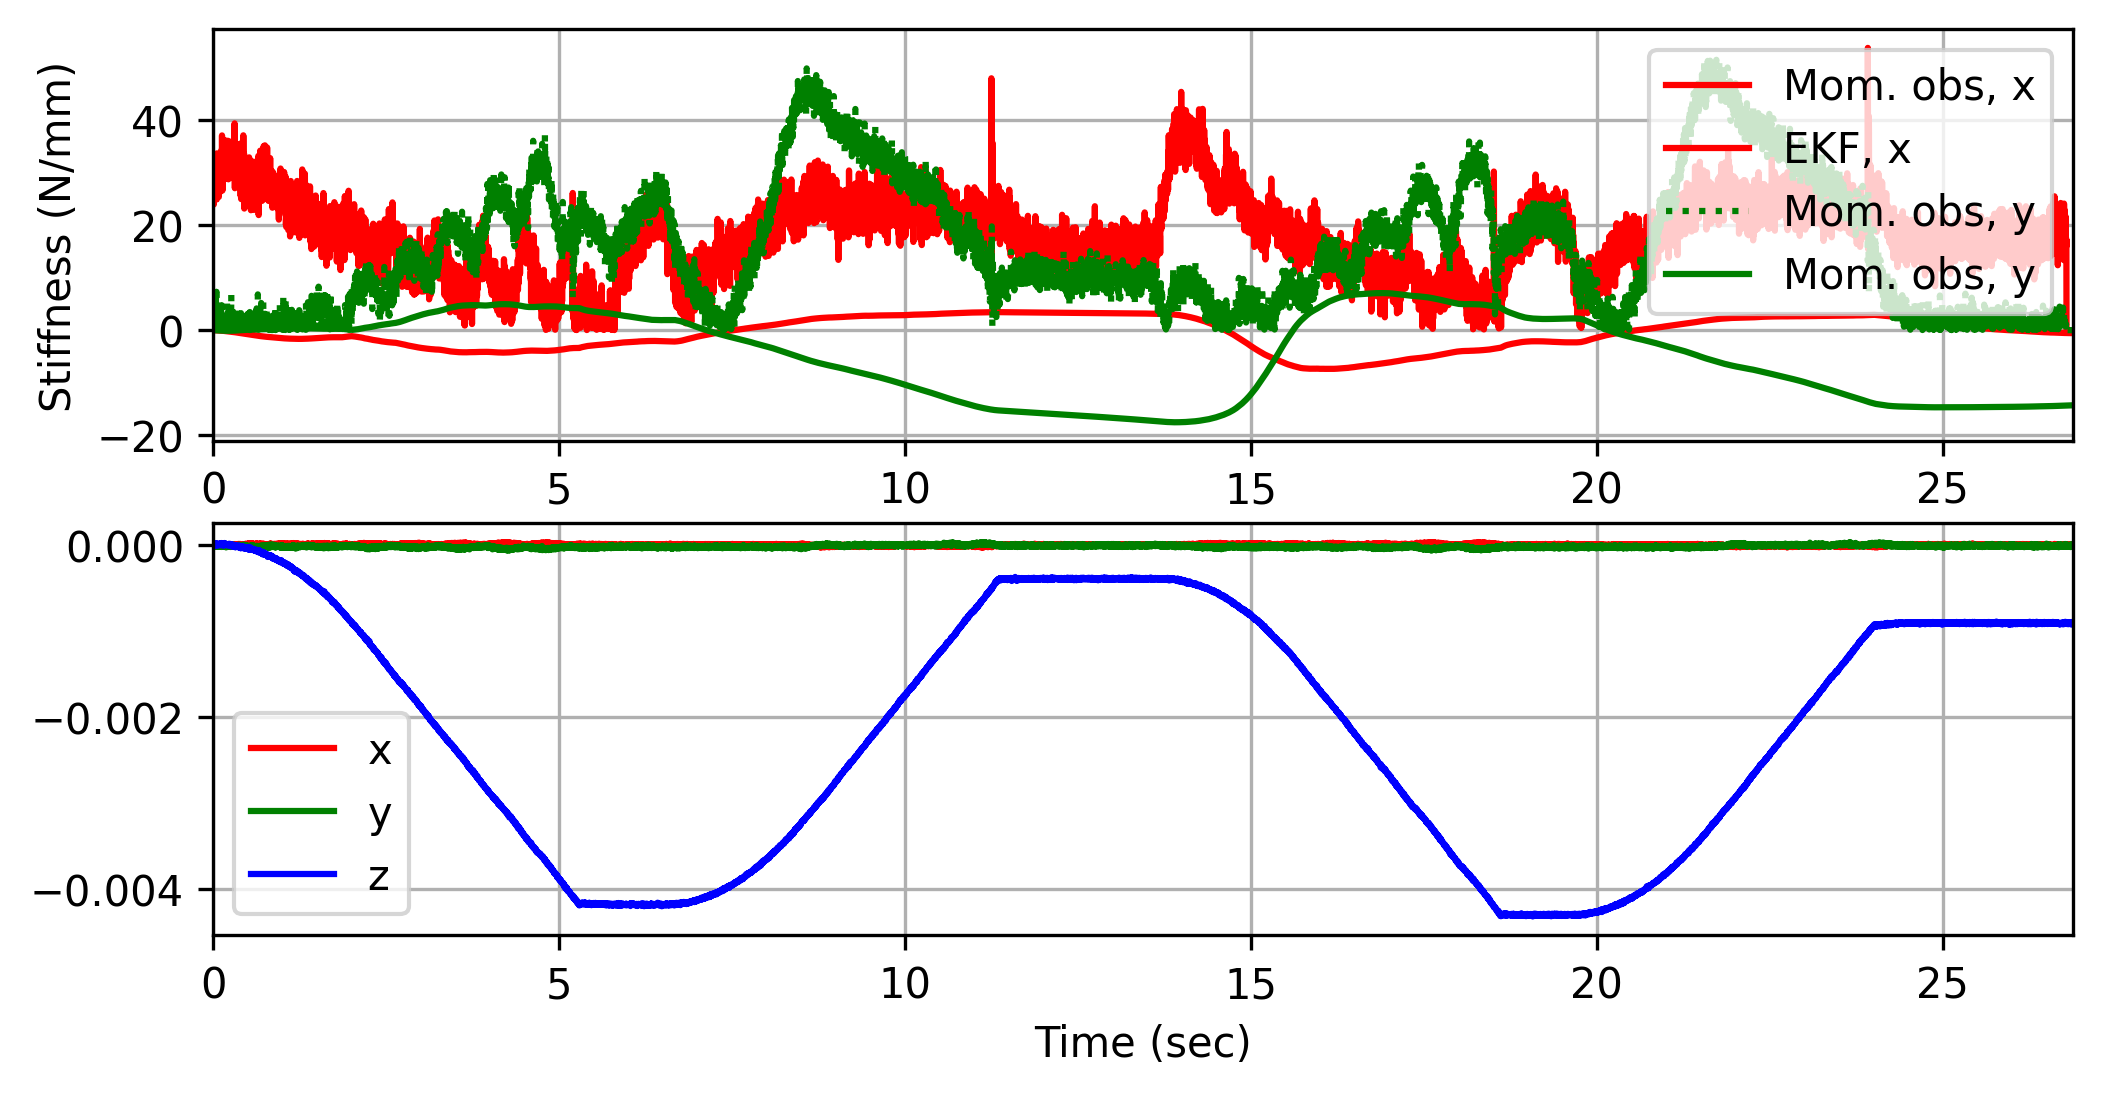

<Figure size 432x288 with 0 Axes>

In [149]:
## Comparing stiffness estimates

traj = 'data/ur_vertical_3_stiff.pkl'
with open(traj, 'rb') as f:
    states, _, _, x_ees, stiff, f_ee_mom_obs, f_ee_obs_stiff, f_ee, _, _ = pickle.load(f)

N = f_ee.shape[1]

# LS estimate of real stiffness
f_ee_w = np.zeros((3, N))
x_reg = np.ones((4,N))

for i in range(N):
    f_ee_w[:,i] = x_ees[i][1]@f_ee[:,i]
    x_reg[:3,i] = x_ees[i][0].squeeze()
    #print(x_reg[:,i])
Kx, _, _, _ = np.linalg.lstsq(x_reg[[0,-1],:].T, f_ee_w[0].T)
Ky, _, _, _ = np.linalg.lstsq(x_reg[[1,-1],:].T, f_ee_w[1].T)
Kz, _, _, _ = np.linalg.lstsq(x_reg[2:,:].T, f_ee_w[2].T)
print(Kx, Ky, Kz)

# Online moving-average first difference estimate
K_online = np.zeros((3,N))
offset = 50
for i in range(N-offset):
    K_online[:,i] = abs((f_ee_mom_obs[:,i+offset]-f_ee[:,i]))/np.array(abs((x_reg[:3,i+offset]-x_reg[:3, i]))).clip(min=5e-4)

# Value estimated by the offline optimization in diff env prim
Kx_offline = 7.3e-7
Ky_offline = 7.1e-6
Kz_offline = 28819.3

t = np.array([range(f_ee.shape[1])]).squeeze()/500.

fig = plt.figure(figsize=(8,5), dpi=plt_dpi)
scale = 1000
plt.plot(t[[0, -1]], [-Kz[0]/scale, -Kz[0]/scale], 'k', label="Least-squares from EE forces")
plt.plot(t, K_online[2]/scale, 'b', label= "First diff estimate w/ mom. obs")
plt.plot(t, -stiff[2]/scale, 'r', label= "EKF estimate")
plt.plot(t[[0, -1]], [Kz_offline/scale, Kz_offline/scale], 'g', label= "Offline fit stiffness")

plt.ylim((-2, 60))
plt.xlim(t[[0,-1]])
plt.grid(True)

plt.ylabel("Stiffness (N/mm)")
plt.xlabel("Time (sec)")
plt.legend()
plt.tight_layout()
#plt.savefig('figs/stiffness.pdf')

fig, axs = plt.subplots(2,1,figsize=(8,4), gridspec_kw={'height_ratios': [1, 1]}, dpi=plt_dpi)
scale = 1000
axs[0].plot(t, K_online[0]/scale, 'r', label= "Mom. obs, x")
axs[0].plot(t, -stiff[0]/scale, 'r', label= "EKF, x")
axs[0].plot(t, K_online[1]/scale, 'g:', label= "Mom. obs, y")
axs[0].plot(t, -stiff[1]/scale, 'g', label= "Mom. obs, y")
axs[0].set_ylabel("Stiffness (N/mm)")

axs[1].plot(t, x_reg[0]-x_reg[0,0], 'r', label= "x")
axs[1].plot(t, x_reg[1]-x_reg[1,0], 'g', label= "y")
axs[1].plot(t, x_reg[2]-x_reg[2,0], 'b', label= "z")

#plt.ylim((-2, 60))
for ax in axs:
    ax.set_xlim(t[[0,-1]])
    ax.grid(True)
    ax.legend()
plt.xlabel("Time (sec)")

plt.show()
plt.tight_layout()

plt.savefig('figs/stiffness_xy_and_motion.pdf')

In [ ]:


#fig = plt.figure(figsize=(12,7))
#jt = 1


#t = np.array([range(f_ee.shape[1])]).squeeze()/500.
#time = range(500,3000)
#plt.plot(time, true_pos[jt,time].T, label="true position")
#plt.plot(time, states[jt,time].T, label="estimated position")
#plt.legend()

#fig = plt.figure(figsize=(12,7))
#plt.plot(time, true_vel[jt,time].T, label="true velocities")
#plt.plot(time, states[jt+6,time].T, label="estimated velocities")

#plt.legend()

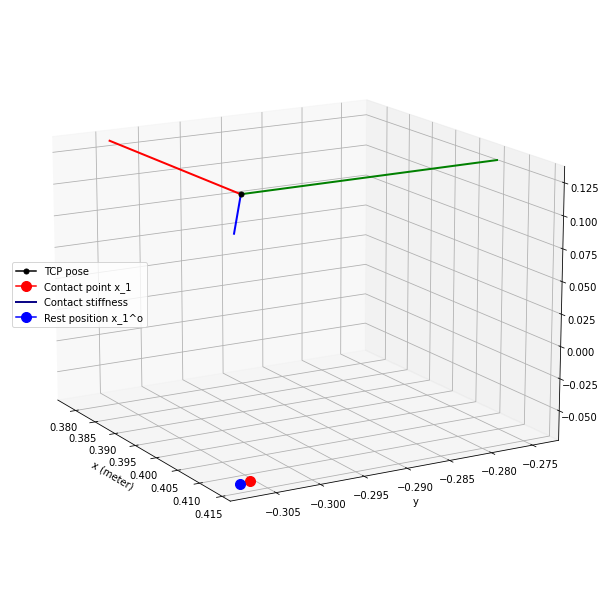

In [3]:
# Plotting the positoin and orientation of the robot and the estimated contact point
#%matplotlib
#traj = 'data/racer_rotate_long_4.pkl'
traj = 'data/ur_vertical_1.pkl'

rest_pos = rospy.get_param('contact_1_rest', [0.0, 0.0, 0.0]) 
#stiff = rospy.get_param('contact_1_stiff', [0.0, 0.0, 0.0]) 
scale = 0.03
scales = 5e-3#3e-6

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection="3d")
with open(traj, 'rb') as f:
    _, _, x_is, x_ees, stiffs = pickle.load(f)

num_pts = x_is.shape[1]
pos_last = x_ees[0][0]
min_dist = 0.008
cmap = plt.get_cmap('plasma')
for i, (xi, xee, stiff) in enumerate(zip(x_is.T, x_ees, stiffs.T)):
    p = np.array(xee[0]).flatten()
    o = np.array(xee[1])
    if np.linalg.norm(p[:3] - pos_last[:3]) < min_dist:
        continue
    else:
        pos_last = p
    x = np.array(o[0,:])
    y = np.array(o[1,:])
    z = np.array(o[2,:])
    xs = o@stiff
    
    ax.plot([p[0], p[0]+scale*x[0]],
            [p[1], p[1]+scale*x[1]],
            [p[2], p[2]+scale*x[2]],
            'r', linewidth=2)
    ax.plot([p[0], p[0]+scale*y[0]],
            [p[1], p[1]+scale*y[1]],
            [p[2], p[2]+scale*y[2]],
            'g', linewidth=2)
    ax.plot([p[0], p[0]+scale*z[0]],
            [p[1], p[1]+scale*z[1]],
            [p[2], p[2]+scale*z[2]],
            'b', linewidth=2)
    h_cs = ax.plot([xi[0], xi[0]-scales*xs[0]],
            [xi[1], xi[1]-scales*xs[1]],
            [xi[2], xi[2]-scales*xs[2]],
            color = cmap(float(i)/num_pts), linewidth=2)[0]
    h_ee = ax.plot(p[0], p[1], p[2], c = 'k', marker = 'o', ms = 5, label='TCP')[0]
    
    h_c1 = ax.plot(xi[0], xi[1], xi[2], c = 'r', marker = 'o', ms = 10, label='Estimated contact')[0]
h_rp1 = ax.plot(rest_pos[0], rest_pos[1], rest_pos[2], c= 'b',  marker = 'o', ms = 10, label='Estimated rest position')[0]
plt.tight_layout()
plt.xlabel('x (meter)')
plt.ylabel('y')
ax.view_init(elev=15., azim=-30.)
plt.legend(handles=[h_ee, h_c1, h_cs, h_rp1],labels=['TCP pose', 'Contact point x_1', 'Contact stiffness', 'Rest position x_1^o'], loc='center left')
plt.subplots_adjust(left=-0.11, right=1.11, bottom=0.0, top=1)
plt.savefig('online_stiff_long.pdf')
plt.show()